In [120]:
import numpy as np
import json

import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from PIL import Image
import requests
from io import BytesIO

# Load hit results

with open('./responses_prod_test.json', 'r') as f:
    results = json.load(f)

print(len(results))

30


In [105]:
def extract_hit_info(r):
    HITId = r['HITId']
    workerId = r['workerId']
    polygons_images = r['results']['outputs'][0]
    feedback = r['feedback']
    
    p_dict = {}
    for polys in polygons_images:
        data = polys.split(':')
        
        if len(data) == 2:
            size_name_raw = data[0]
            points_raw = data[1]
        else:
            size_name_raw = data[0]+':'+data[1]
            points_raw = data[2]
            
        size_name = size_name_raw.split(',')
        size = (int(size_name[0]),int(size_name[1]))
        name = size_name[2]
        
        print(size_name,name)
        
        p_dict[name] = dict(size=size, points=points_raw.split(';')[:-1])
        
    return HITId, workerId, p_dict, feedback
    
    
    
def visualize_polygons(img_name, size, points, prefix_files =True, image_from_web=True):
    
    if image_from_web:
        response = requests.get(img_name)
        image = Image.open(BytesIO(response.content))

    else:
    
        if prefix_files:
            image = Image.open(img_name[2:])
        else:
            image = Image.open(img_name)
    
    image = image.convert('RGB')
    draw = ImageDraw.Draw(image, 'RGBA')


    image = draw_polygons(image,draw,size,points,fill=(255,0,0,100))
    
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()
    

def draw_polygons(image, draw, size, points, fill=1):
    
    factor_x = image.width/(size[0])
    factor_y = image.height/(size[1])
    
    marg_x = -10*factor_x
    marg_y = -10*factor_y
    
    
    for p in points:
        p = p.split(',')
        print('p[:3]',p[:3])
#         print('p',p)

            

        if p[1]=='1':
            # Turker used Regular Stroke, we need to use draw.ellipse
            r = float(p[0])
            for i in range(3,len(p)-3,2) :
                draw.ellipse((float(p[i])-r, float(p[i+1])-r, float(p[i])+r, float(p[i+1])+r), fill=fill)
        else:
            # Turker used Fill, we need to use draw.polygon 
            pts = [(float(p[i])*factor_x+marg_x, float(p[i+1])*factor_y+marg_y) for i in range(3,len(p)-3,2)]
            if len(pts)<4:
                continue
            draw.polygon(pts, fill=fill)
    
    return image
    
def average_save_labels(img_name, size, point_arrays, prefix_files=True, save_path=None):
    
    # TODO: FINISH THIS FUNCTION
    
    if prefix_files:
        image = Image.open('./files/'+img_name[2:])
    else:
        image = Image.open(img_name)
    
    
    masks = np.zeros((image.width, image.height))
    
    for pts in point_arrays:
        mask = Image.new('L', (image.width, image.height), 0)
        draw = ImageDraw.Draw(mask)
        mask = draw_polygons(mask, draw, size, points, fill=1)
        mask = numpy.array(mask)
        
        masks+=mask
    
#     masks/=
    
    im = Image.fromarray(masks)
    im.save(save_path)
    
    
def average_with_existing(existing, save_path=None):
    pass
    

['240', '600', 'https://www.dropbox.com/s/ievwpfwk2b7ri42/infographics_1_26_MACW2lF5fbY.png?raw=1'] https://www.dropbox.com/s/ievwpfwk2b7ri42/infographics_1_26_MACW2lF5fbY.png?raw=1
['240', '600', 'https://www.dropbox.com/s/u280x42t6d776nh/infographics_2_8_MAB0KR3AYs4.png?raw=1'] https://www.dropbox.com/s/u280x42t6d776nh/infographics_2_8_MAB0KR3AYs4.png?raw=1
['240', '600', 'https://www.dropbox.com/s/gilx78wjivufy0n/infographics_1_3_MAB2CQ_1UW0.png?raw=1'] https://www.dropbox.com/s/gilx78wjivufy0n/infographics_1_3_MAB2CQ_1UW0.png?raw=1
['240', '600', 'https://www.dropbox.com/s/wbgfde8x63fd0ln/infographics_2_16_MAB1G1BwzUk.png?raw=1'] https://www.dropbox.com/s/wbgfde8x63fd0ln/infographics_2_16_MAB1G1BwzUk.png?raw=1
['240', '600', 'https://www.dropbox.com/s/td3jn1wfj5jicvd/infographics_2_26_MABOYVh4Qpw.png?raw=1'] https://www.dropbox.com/s/td3jn1wfj5jicvd/infographics_2_26_MABOYVh4Qpw.png?raw=1
['240', '600', 'https://www.dropbox.com/s/awt47hj69vvwdrr/infographics_2_19_MAB1xDV3wvQ.png?ra

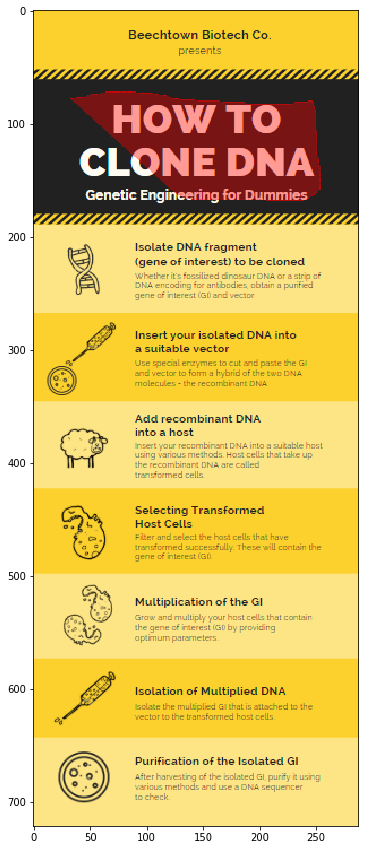

p[:3] ['3', '4', '1']


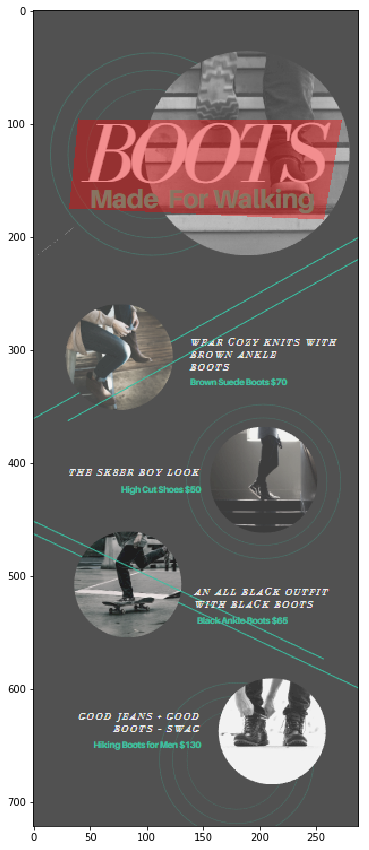

p[:3] ['3', '4', '1']


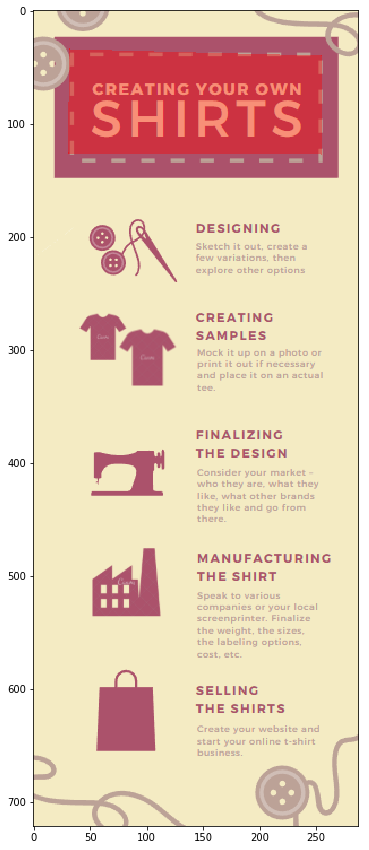

p[:3] ['3', '4', '1']


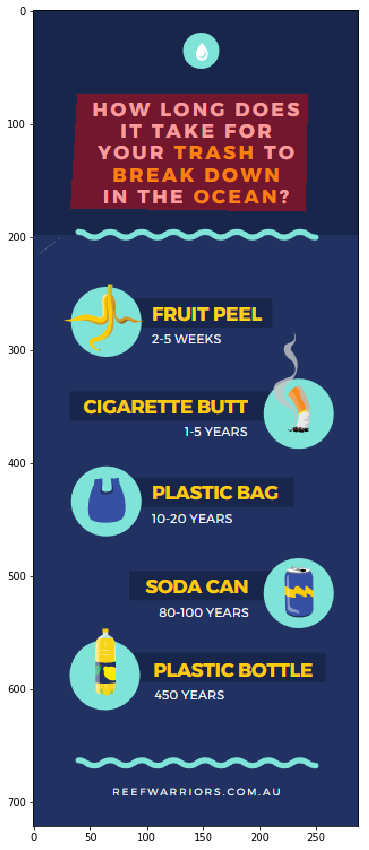

p[:3] ['3', '4', '1']


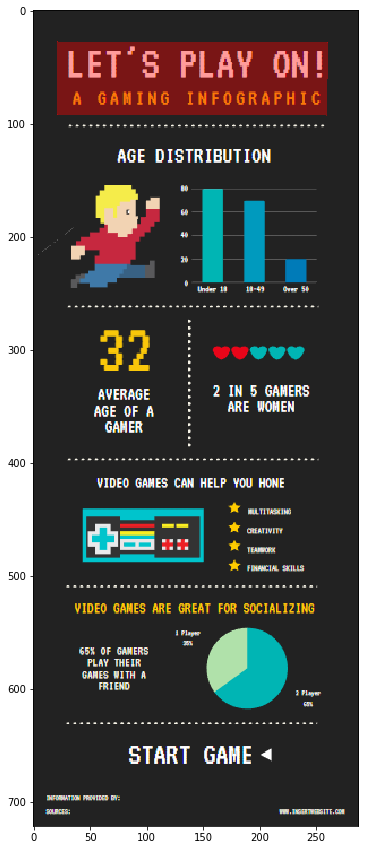

p[:3] ['3', '4', '1']


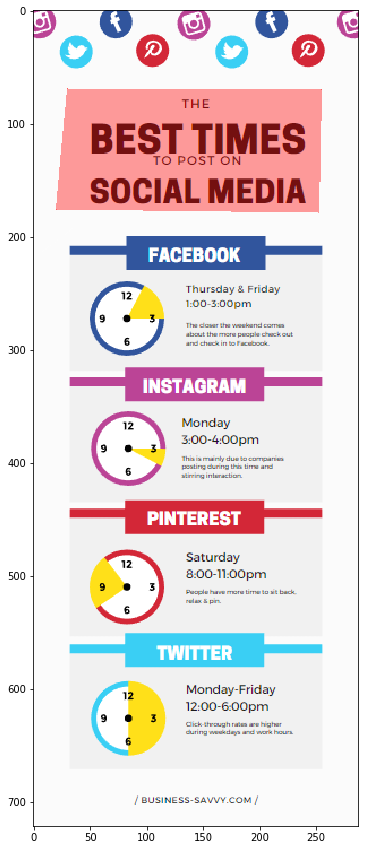

p[:3] ['3', '4', '1']


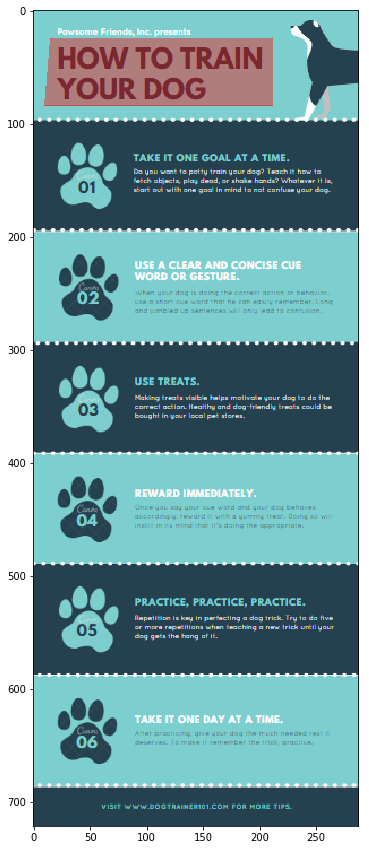

p[:3] ['3', '4', '1']


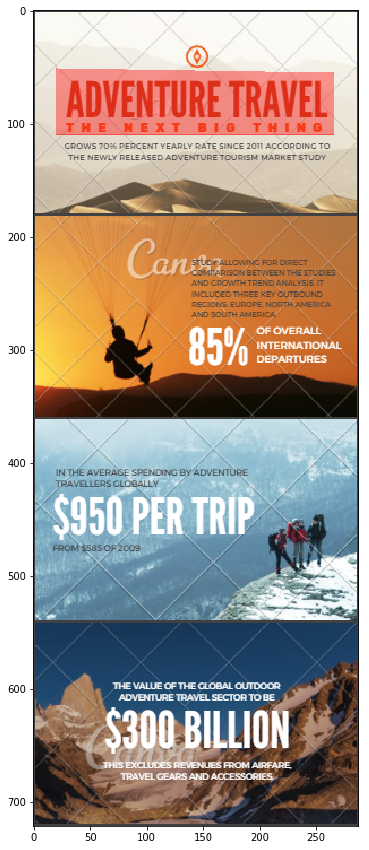

p[:3] ['3', '4', '1']


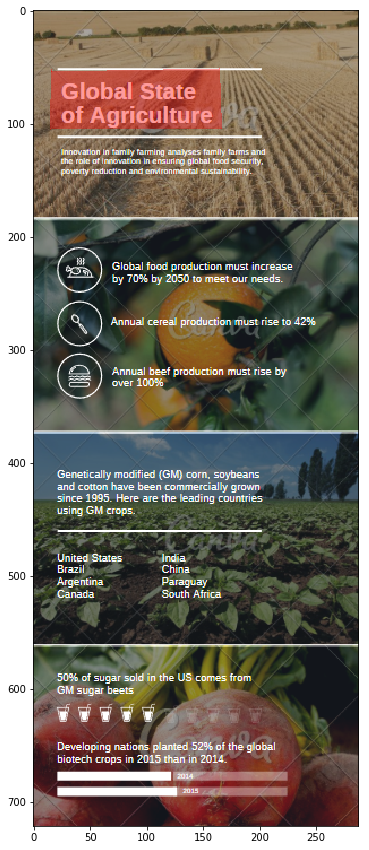

p[:3] ['3', '4', '1']


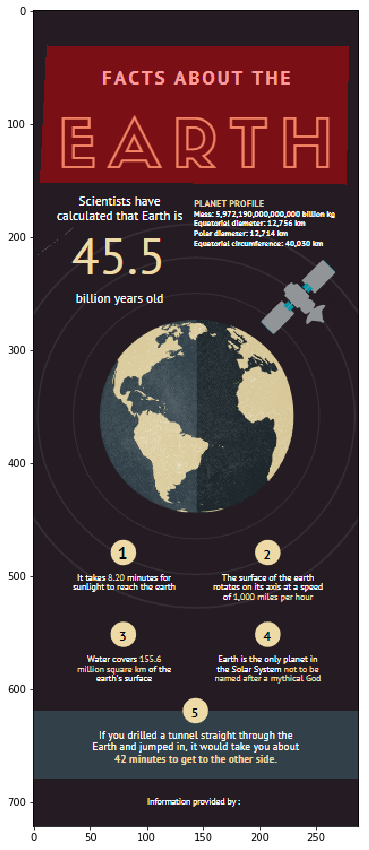

In [135]:
HITId, workerId, p_dict, feedback = extract_hit_info(results[21])

# print(p_dict)

for name, pts in p_dict.items():
    # Pts are dictionary of size, points
    size = pts['size']
    p = pts['points']

    visualize_polygons(name, size, p, image_from_web=True)
